In [3]:
import numpy as np
import tqdm 
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl 
import astropy.units as u
from astropy.constants import G, M_sun
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys

sys.path.append('../pipeline_scripts/')
from pipeline_main import pipeline, dist, calc_ang
from pipeline_2D import to_osyris_ivs

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}
mpl.rc('font', **font)

In [4]:
#data = pipeline(snap = 608, run = 'sink225fmr05', sink_id = 225)
data = pipeline(snap = 392, run = 'sink13fmr05', sink_id=13)
data.recalc_L(radius=100)

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4165/4165 [01:40<00:00, 41.56it/s] 


Converged mean angular momentum vector after 1 iteration(s)


In [5]:
#data = pipeline(snap = 524, run = 'sink180fmr05', sink_id = 178)

In [6]:
print('Code length to au',data.au_length)
print('Code density (values)', data.cgs_density)

Code length to au 825133.6898395722
Code density (values) 3.187e-21


In [7]:
#data.recalc_L()
data.calc_trans_xyz()

Transforming old z-coordinate into mean angular momentum vector


  0%|          | 0/4165 [00:00<?, ?it/s]

100%|██████████| 4165/4165 [00:02<00:00, 2009.83it/s]


In [8]:
data.L

array([ 0.9079172 , -0.33387467,  0.25340492])

In [9]:
for p in tqdm.tqdm(data.sn.patches):
    p.vx, p.vy, p.vz = p.trans_vrel
    p.B = np.concatenate([p.var(f'b'+axis)[None,...] for axis in ['x','y','z']], axis = 0)
    p.Bx = np.sum(data.new_x[:,None, None, None] * p.B, axis = 0)
    p.By = np.sum(data.new_y[:,None, None, None] * p.B, axis = 0)
    p.Bz = np.sum(data.L[:,None, None, None] * p.B, axis = 0)

  0%|          | 0/4165 [00:00<?, ?it/s]

100%|██████████| 4165/4165 [00:15<00:00, 277.09it/s]


In [10]:
res = 1000; width = 4000 
variable_d = ['d']

In [12]:
data.to_osyris_ivs(variables=variable_d, data_name = 'face_on_dens', view = width, resolution=res, viewpoint='top' , weights=None)


Looping over DISPATCH data to extract data at highest level


100%|██████████| 2190/2190 [00:32<00:00, 67.33it/s] 


Setting up Osyris data structure


In [13]:
data.to_osyris_ivs(variables=variable_d, data_name = 'edge_on_dens', view = width, resolution=res, viewpoint = 'edge', weights=None)


Looping over DISPATCH data to extract data at highest level


100%|██████████| 2190/2190 [00:22<00:00, 99.14it/s] 


Setting up Osyris data structure


In [14]:
variable_v =  ['vx', 'vy', 'vz']

In [15]:
data.to_osyris_ivs(variables=variable_v, data_name = 'face_on_vel', view = width, resolution=res, viewpoint='top' , weights='mass')


Looping over DISPATCH data to extract data at highest level


  0%|          | 0/2190 [00:00<?, ?it/s]

100%|██████████| 2190/2190 [00:07<00:00, 307.49it/s]


Setting up Osyris data structure


In [16]:
data.osyris_ivs.keys()

dict_keys(['face_on_dens', 'edge_on_dens', 'face_on_vel'])

In [17]:
data.to_osyris_ivs(variables=variable_v, data_name = 'edge_on_vel', view = width, resolution=res, viewpoint='edge' , weights='mass')

Looping over DISPATCH data to extract data at highest level


  0%|          | 0/2190 [00:00<?, ?it/s]

100%|██████████| 2190/2190 [00:08<00:00, 251.40it/s]


Setting up Osyris data structure


In [18]:
vx_e, vy_e, vz_e = np.array([data.osyris_ivs['edge_on_vel'][ivs] for ivs in variable_v]) * data.cms_velocity
vx_f, vy_f, vz_f = np.array([data.osyris_ivs['face_on_vel'][ivs] for ivs in variable_v]) * data.cms_velocity

In [19]:
data.L

array([ 0.9079172 , -0.33387467,  0.25340492])

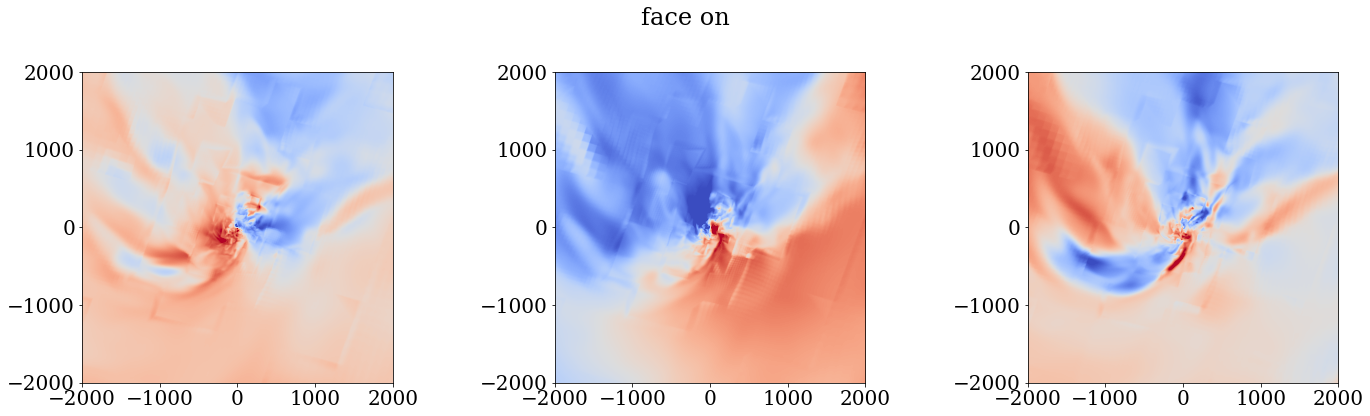

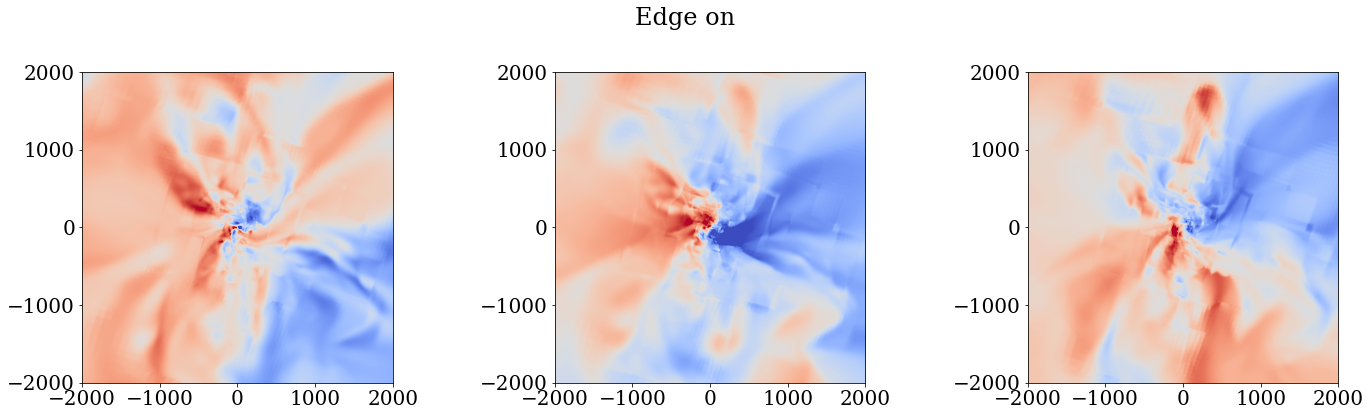

In [20]:
fig, axs = plt.subplots(1,3, figsize = (20,6))
ext = width // 2
for vel, ax in zip([vx_f, vy_f, vz_f], axs.flatten()):
    ax.imshow(vel, cmap = 'coolwarm', extent = (-ext, ext, -ext, ext), vmin = -1e5, vmax = 1e5, origin = 'lower')
fig.suptitle('face on')
fig.tight_layout()

fig, axs = plt.subplots(1,3, figsize = (20,6))
ext = width // 2
for vel, ax in zip([vx_e, vy_e, vz_e], axs.flatten()):
    ax.imshow(vel, cmap = 'coolwarm', extent = (-ext, ext, -ext, ext), vmin = -1e5, vmax = 1e5, origin = 'lower')
plt.suptitle('Edge on')
plt.tight_layout()



In [21]:
vel_face_on = np.array([vx_f, vy_f])
velnorm_face_on = np.sqrt(vel_face_on[0,...]**2 + vel_face_on[1,...]**2)

vel_edge_on = np.array([vy_e, vz_e])
velnorm_edge_on = np.sqrt(vel_edge_on[0,...]**2 + vel_edge_on[1,...]**2)


X, Y = [np.linspace(-width //2, width // 2, res) for _ in range(2)]
xx,yy = np.meshgrid(X, Y)



In [22]:
p.ds[0] * data.au_length

1611.5892379679144

In [23]:
data.cgs_density

3.187e-21

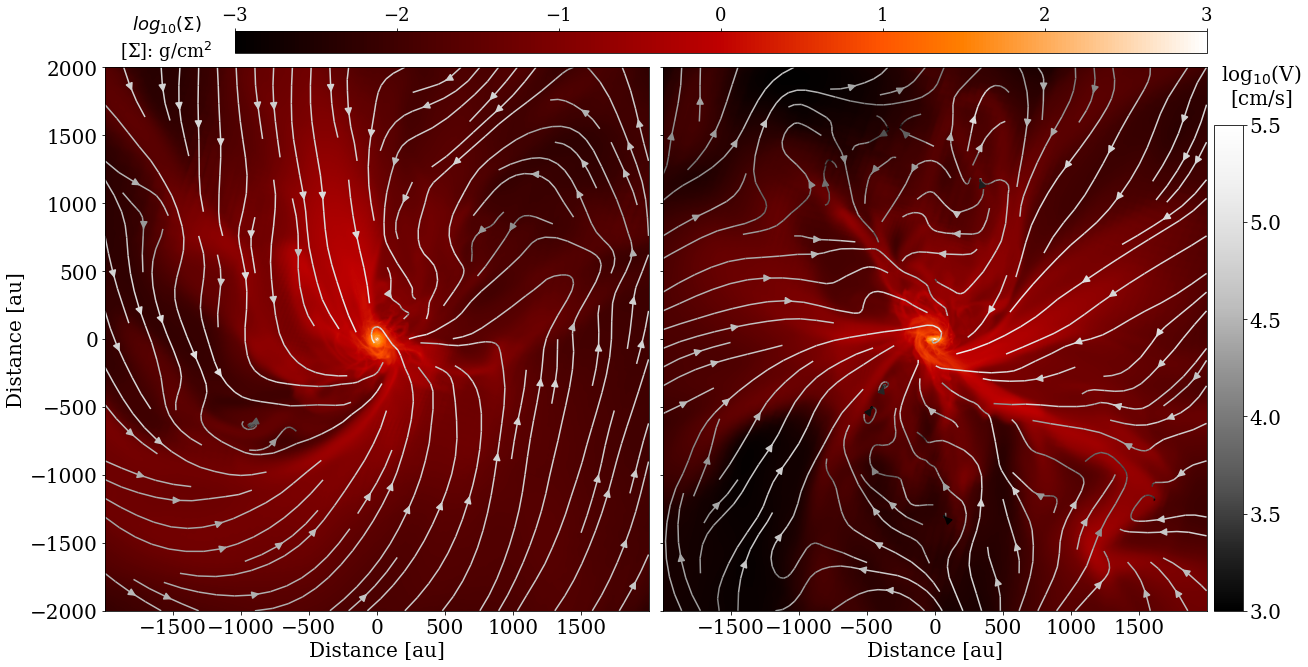

In [24]:
Σ_face_on = data.osyris_ivs['face_on_dens']['d'] * data.cgs_density
Σ_edge_on = data.osyris_ivs['edge_on_dens']['d'] * data.cgs_density
ext = width // 2


skip_ticks = width // 8
xticks = np.arange(- skip_ticks * 3, skip_ticks * 4, skip_ticks)

density = 1
vmin_colormap, vmax_colormap = -3, 3
vmin_strm, vmax_strm = 3, 5.5

norm = mpl.colors.Normalize(vmin=vmin_strm, vmax=vmax_strm)

fig, axs = plt.subplots(1, 2, figsize = (20, 10), sharey=True)

for ax in axs:
    ax.set_xticks(xticks)

ax = axs[0]
ax.set(xlabel = 'Distance [au]', ylabel = 'Distance [au]', xlim = (-ext, ext), ylim = (-ext, ext))
cs = ax.imshow(np.log10(Σ_face_on), extent = (-ext, ext, -ext, ext), origin ='lower', cmap = 'gist_heat', vmin = vmin_colormap, vmax = vmax_colormap)
strm  = ax.streamplot(X, Y, vel_face_on[0,...] , vel_face_on[1,...], color = np.log10(velnorm_face_on), cmap=mpl.cm.Greys_r, arrowsize=1.5, norm = norm, density = density)

ax = axs[1]
ax.set(xlabel = 'Distance [au]', xlim = (-ext, ext), ylim = (-ext, ext))
cs = ax.imshow(np.log10(Σ_edge_on), extent = (-ext, ext, -ext, ext), origin ='lower', cmap = 'gist_heat', vmin = vmin_colormap, vmax = vmax_colormap)
strm  = ax.streamplot(X, Y, vel_edge_on[0,...] , vel_edge_on[1,...], color = np.log10(velnorm_edge_on), cmap=mpl.cm.Greys_r, density = density, arrowsize=1.5, norm = norm)

colorbar_cmap = fig.add_axes([0.22, 0.9, 0.675, 0.03])
cbar = fig.colorbar(cs, cax = colorbar_cmap,  orientation = 'horizontal')
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_label('$log_{10}(Σ)$\n[Σ]: g/cm$^2$', labelpad = -40, x = -0.07, rotation = 0, fontsize = 18)
cbar.ax.tick_params(labelsize=18)

colorbar_strm = fig.add_axes([0.9, 0.125, 0.02, 0.675])
cbar_strm = fig.colorbar(strm.lines, cax = colorbar_strm)
cbar_strm.set_label('log$_{10}$(V)\n[cm/s]', labelpad = -20, y = 1.13, rotation = 0, fontsize = 20)
#fig.suptitle('Time after formation: ',size=30, y=1.0)

fig.subplots_adjust(wspace=0, hspace=0.2)

In [ ]:
variable_b =  ['Bx', 'By', 'Bz']

In [ ]:
data.to_osyris_ivs(variables=variable_b, data_name = 'face_on_B', view = width, resolution=res, viewpoint='top' , weights='volume',  dz = 20)


Looping over DISPATCH data to extract data at highest level


  0%|          | 0/1677 [00:00<?, ?it/s]

100%|██████████| 1677/1677 [00:07<00:00, 238.43it/s]


Setting up Osyris data structure


In [ ]:
data.to_osyris_ivs(variables=variable_b, data_name = 'edge_on_B', view = width, resolution=res, viewpoint='edge' , weights='volume',  dz = 20)


Looping over DISPATCH data to extract data at highest level


100%|██████████| 1677/1677 [00:05<00:00, 324.48it/s]


Setting up Osyris data structure


In [ ]:
bx_e, by_e, bz_e = np.array([data.osyris_ivs['edge_on_B'][ivs] for ivs in variable_b]) * data.sn.scaling.b
bx_f, by_f, bz_f = np.array([data.osyris_ivs['face_on_B'][ivs] for ivs in variable_b]) * data.sn.scaling.b

/tmp/ipykernel_2766021/3292955173.py:4: RuntimeWarning: invalid value encountered in log10
  ax.imshow(np.log10(vel), cmap = 'coolwarm', extent = (-ext, ext, -ext, ext), vmax = -2, vmin = -5, origin = 'lower')
/tmp/ipykernel_2766021/3292955173.py:11: RuntimeWarning: invalid value encountered in log10
  ax.imshow(np.log10(vel), cmap = 'coolwarm', extent = (-ext, ext, -ext, ext), vmax = -2, vmin = -5, origin = 'lower')


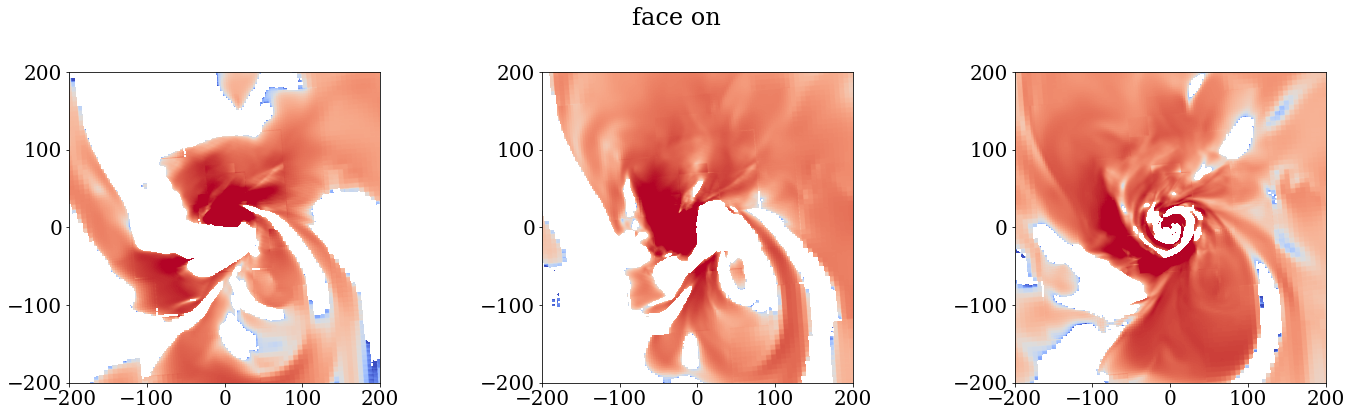

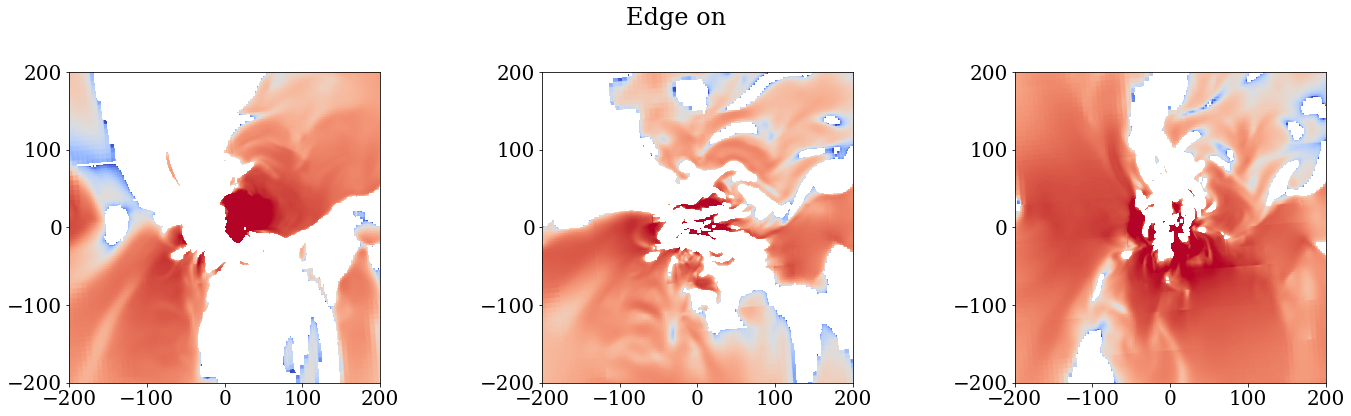

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (20,6))
ext = width // 2
for vel, ax in zip([bx_f, by_f, bz_f], axs.flatten()):
    ax.imshow(np.log10(vel), cmap = 'coolwarm', extent = (-ext, ext, -ext, ext), vmax = -2, vmin = -5, origin = 'lower')
fig.suptitle('face on')
fig.tight_layout()

fig, axs = plt.subplots(1,3, figsize = (20,6))
ext = width // 2
for vel, ax in zip([bx_e, by_e, bz_e], axs.flatten()):
    ax.imshow(np.log10(vel), cmap = 'coolwarm', extent = (-ext, ext, -ext, ext), vmax = -2, vmin = -5, origin = 'lower')
plt.suptitle('Edge on')
plt.tight_layout()



In [ ]:
B_face_on = np.array([bx_f, by_f])
Bnorm_face_on = np.sqrt(vel_face_on[0,...]**2 + vel_face_on[1,...]**2)

B_edge_on = np.array([by_e, bz_e])
Bnorm_edge_on = np.sqrt(vel_edge_on[0,...]**2 + vel_edge_on[1,...]**2)


X, Y = [np.linspace(-width //2, width // 2, res) for _ in range(2)]


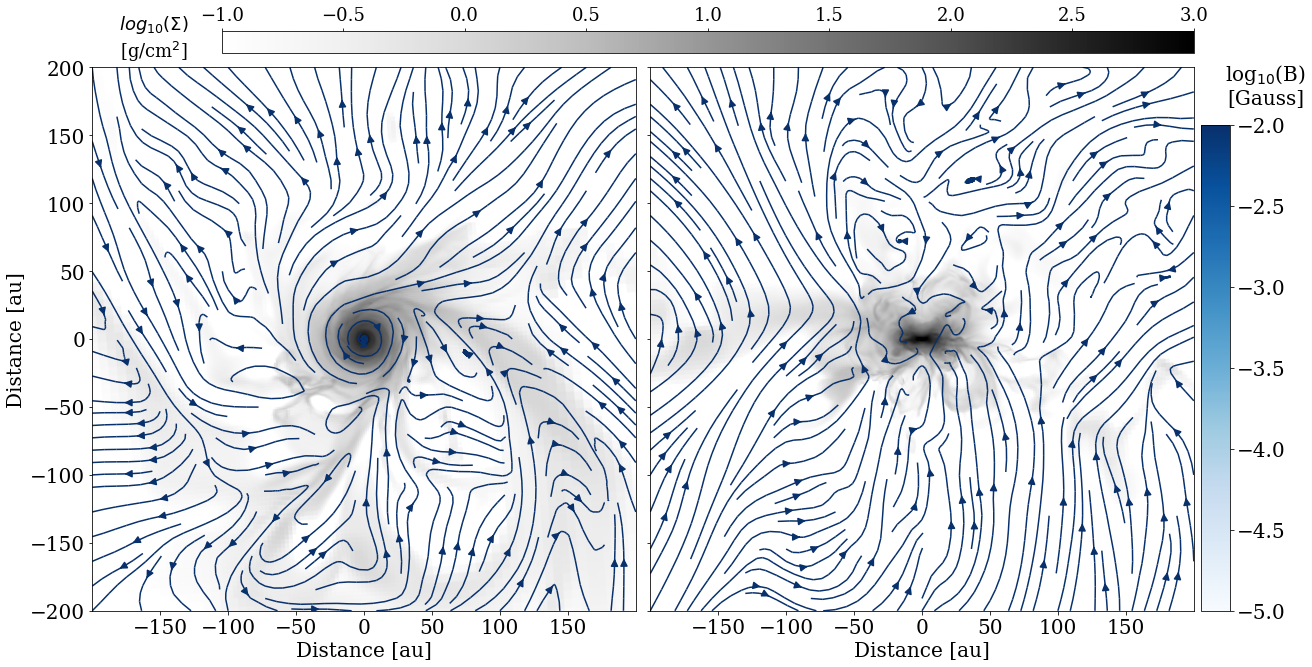

In [ ]:
ext = width // 2

density = 1.5
vmin_colormap, vmax_colormap = -1, 3
vmin_strm, vmax_strm = -5, -2

norm = mpl.colors.Normalize(vmin=vmin_strm, vmax=vmax_strm)

fig, axs = plt.subplots(1, 2, figsize = (20, 10), sharey=True)

for ax in axs:
    ax.set_xticks(xticks)

ax = axs[0]
ax.set(xlabel = 'Distance [au]', ylabel = 'Distance [au]', xlim = (-ext, ext), ylim = (-ext, ext))
cs = ax.imshow(np.log10(Σ_face_on), extent = (-ext, ext, -ext, ext), origin ='lower', cmap = 'Greys', vmin = vmin_colormap, vmax = vmax_colormap)
strm  = ax.streamplot(X, Y,  B_face_on[0,...] , B_face_on[1,...], color = np.log10(Bnorm_face_on), cmap=mpl.cm.Blues, arrowsize=1.5, norm = norm, density = density)

ax = axs[1]
ax.set(xlabel = 'Distance [au]', xlim = (-ext, ext), ylim = (-ext, ext))
#cs = ax.imshow(V_jet, extent = (-ext, ext, -ext, ext), origin ='lower', cmap = 'coolwarm', norm = colors.SymLogNorm(linthresh=1e1, linscale=0.5, vmin = -1e5, vmax = 1e5))
cs = ax.imshow(np.log10(Σ_edge_on), extent = (-ext, ext, -ext, ext), origin ='lower', cmap = 'Greys', vmin = vmin_colormap, vmax = vmax_colormap)
strm  = ax.streamplot(X, Y, B_edge_on[0,...] , B_edge_on[1,...], color = np.log10(Bnorm_edge_on), cmap=mpl.cm.Blues, density = density, arrowsize=1.5, norm = norm)

colorbar_cmap = fig.add_axes([0.22, 0.9, 0.675, 0.03])
cbar = fig.colorbar(cs, cax = colorbar_cmap,  orientation = 'horizontal')
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_label('$log_{10}(Σ)$\n[g/cm$^2$]', labelpad = -40, x = -0.07, rotation = 0, fontsize = 18)
cbar.ax.tick_params(labelsize=18)

colorbar_strm = fig.add_axes([0.9, 0.125, 0.02, 0.675])
cbar_strm = fig.colorbar(strm.lines, cax = colorbar_strm)
cbar_strm.set_label('log$_{10}$(B)\n[Gauss]', labelpad = -20, y = 1.13, rotation = 0, fontsize = 20)


fig.subplots_adjust(wspace=0, hspace=0.2)